In [67]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.origin'] = 'lower'
plt.style.use('ggplot')
import astropy.units as u
import astropy.constants as const
import ipywidgets as widgets
import ipywidgets
from IPython.display import clear_output

import utils
from kernel_nuller import KN0

# Kernel Nulling instance

In [68]:
kn0 = KN0(
    shifters_offset=[0, 0, 0.5, 0, 0.2, 0, 0.6, 0, -0.9, 0, 0, 0, 0, 0],
    input_phase_rms=0.001,
    inner_phase_rms=0.01
)

star_light = np.array([
    np.exp(0j),
    np.exp(0j),
    np.exp(0j),
    np.exp(0j),
], dtype=complex)

contrast = 1e-2
planet_light = np.array([
    contrast * np.exp(1j * 0.10),
    contrast * np.exp(1j * -0.12),
    contrast * np.exp(1j * 0.05),
    contrast * np.exp(1j * -0.01),
], dtype=complex)

<div align=center>

---

# GUI

</div>

In [69]:
max_power = 1
step = 1e-20

# Build sliders
P_sliders = [widgets.FloatSlider(value=0, min=-max_power, max=max_power, step=step, description=f"P{i+1}") for i in range(14)]

bright, darks, intermediate = kn0(star_light)

def beam_repr(beam:complex) -> str:
    return f"{np.abs(beam):.3e} * exp({np.angle(beam)/np.pi:.3e} pi i)"   

inputs = [widgets.Label(value=f" ") for _ in range(4)]
first_nuller_layer = [widgets.Label(value=f" ") for _ in range(4)]
second_nuller_layer = [widgets.Label(value=f" ") for _ in range(4)]
outputs = [widgets.Label(value=f" ") for _ in range(7)]

def update_gui(*args):

    kn0.shift_powers = np.array([x.value for x in P_sliders])

    bright, darks, inter = kn0(star_light)

    for i, beam in enumerate(inter['inputs']):
        inputs[i].value = f"Input {i+1}: {beam_repr(beam)}"

    for i, beam in enumerate(inter['first_nuller_layer']):
        first_nuller_layer[i].value = f"N{i//2+1} : {i%2}: {beam_repr(beam)}"

    for i, beam in enumerate(inter['second_nuller_layer']):
        second_nuller_layer[i].value = f"N{i//2+3} : {i%2}: {beam_repr(beam)}"

    outputs[0].value = f"Bright : {beam_repr(bright)}"
    for i, beam in enumerate(darks): 
        outputs[i+1].value = f"Dark {i+1}: {beam_repr(beam)}"

    return bright, darks


for widget in P_sliders:
    widget.observe(update_gui, 'value')

empty = widgets.Label()

vbox = widgets.VBox([
    *[widgets.HBox([x]) for x in inputs],

    widgets.Label("1st nuller layer phase corrective powers:"),
    widgets.HBox(P_sliders[:4]),

    *[widgets.HBox([x]) for x in first_nuller_layer],

    widgets.Label("2nd nuller layer phase corrective powers:"),
    widgets.HBox(P_sliders[4:8]),
    
    *[widgets.HBox([x]) for x in second_nuller_layer],

    widgets.Label("Split & Mix phase corrective powers:"),
    widgets.HBox(P_sliders[8:11]),
    widgets.HBox(P_sliders[11:14]),

    *[widgets.HBox([x]) for x in outputs],
])

update_gui()
vbox

<div align=center>

---

# Convergence

</div>

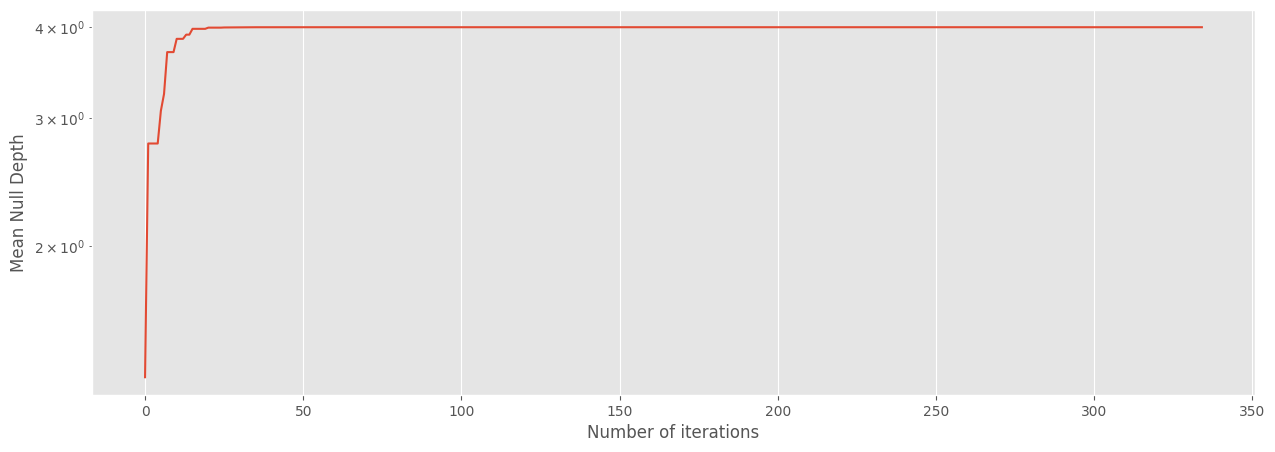

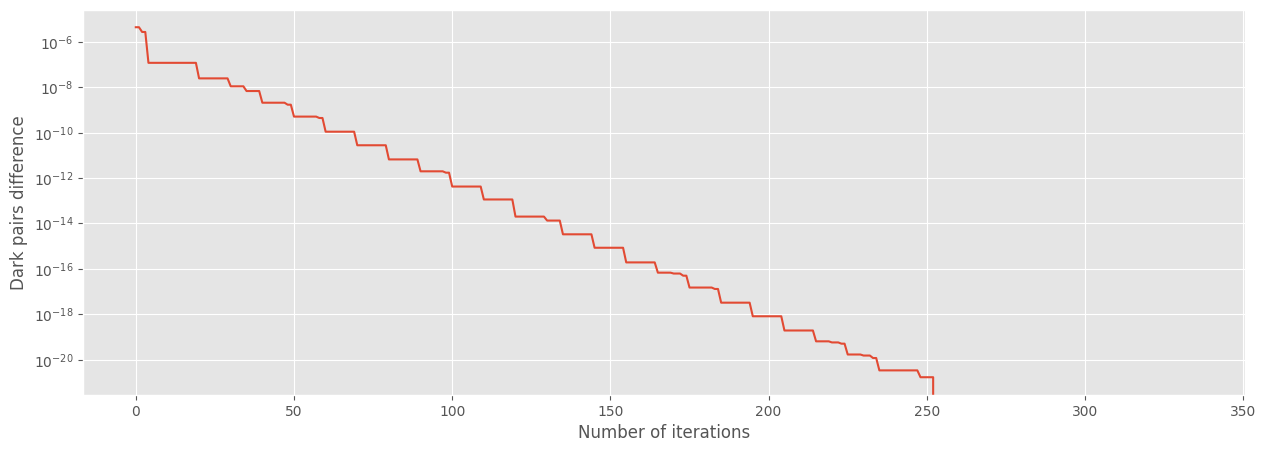

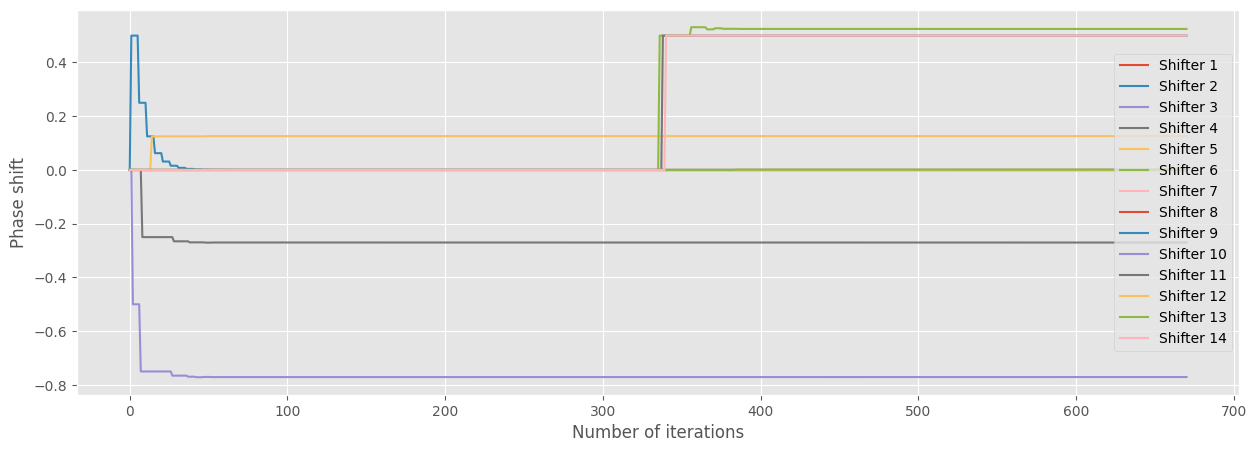

Optimized parameters | Introduced error
P1 = 0.00e+00 | 0.00e+00
P2 = 4.55e-13 | 1.64e-03
P3 = -7.71e-01 | 5.03e-01
P4 = -2.70e-01 | -1.57e-04
P5 = 1.26e-01 | 1.98e-01
P6 = 5.25e-01 | 8.06e-03
P7 = 4.55e-13 | 5.94e-01
P8 = 0.00e+00 | -7.11e-03
P9 = 0.00e+00 | -8.90e-01
P10 = 0.00e+00 | -1.07e-02
P11 = 5.00e-01 | -4.44e-03
P12 = 0.00e+00 | 1.52e-02
P13 = 1.22e-03 | 7.52e-03
P14 = 5.00e-01 | -2.23e-02


In [70]:
optimized_parameters = kn0.shift_powers
optimized_parameters, bright_evol, dark_symmetry_evol, shifts_evol = utils.optimize(kn0, star_light, verbose=False)

plt.figure(figsize=(15, 5))
plt.plot(bright_evol)
plt.xlabel("Number of iterations")
plt.ylabel("Mean Null Depth")
plt.yscale("log")
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(dark_symmetry_evol)
plt.xlabel("Number of iterations")
plt.ylabel("Dark pairs difference")
plt.yscale("log")
plt.show()

plt.figure(figsize=(15, 5))
for i in range(len(kn0.shift_powers)):
    plt.plot(shifts_evol[:,i], label=f"Shifter {i+1}")
plt.xlabel("Number of iterations")
plt.ylabel("Phase shift")
plt.yscale("linear")
plt.legend()
plt.show()

# Ignoring global phase
introduced_error = kn0.shifters_noise + kn0.shifters_offset
introduced_error -= introduced_error[0]
optimized_parameters -= optimized_parameters[0]
optimized_parameters = utils.bound_phase(optimized_parameters)

print("Optimized parameters | Introduced error")
for i in range(14):
    print(f"P{i+1} = {optimized_parameters[i]:.2e} | {introduced_error[i]:.2e}")

# Cheat code :
# optimized_parameters = -introduced_error

# Parameter impact

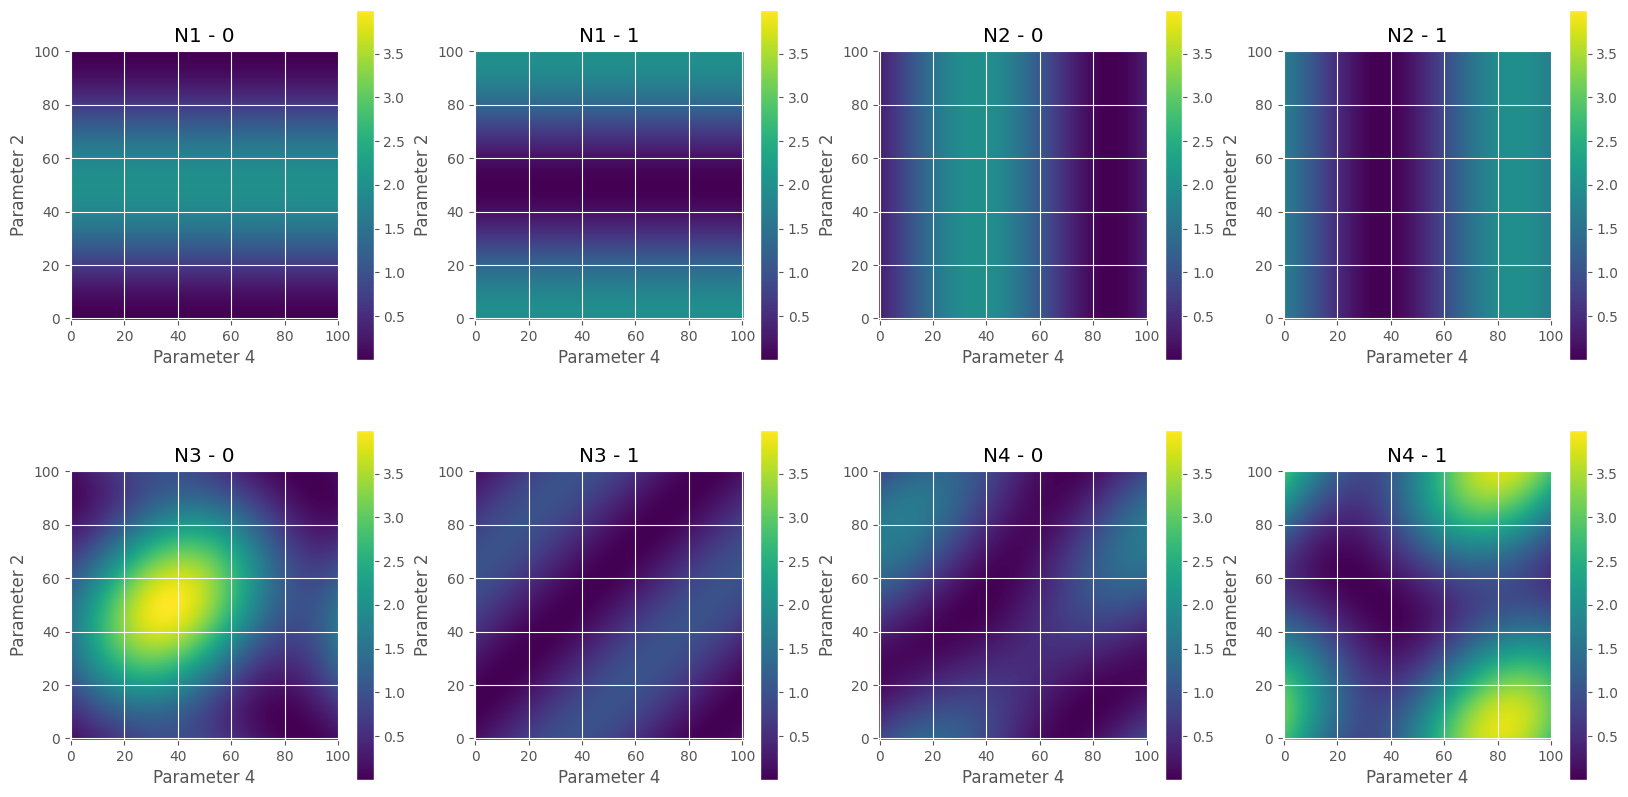

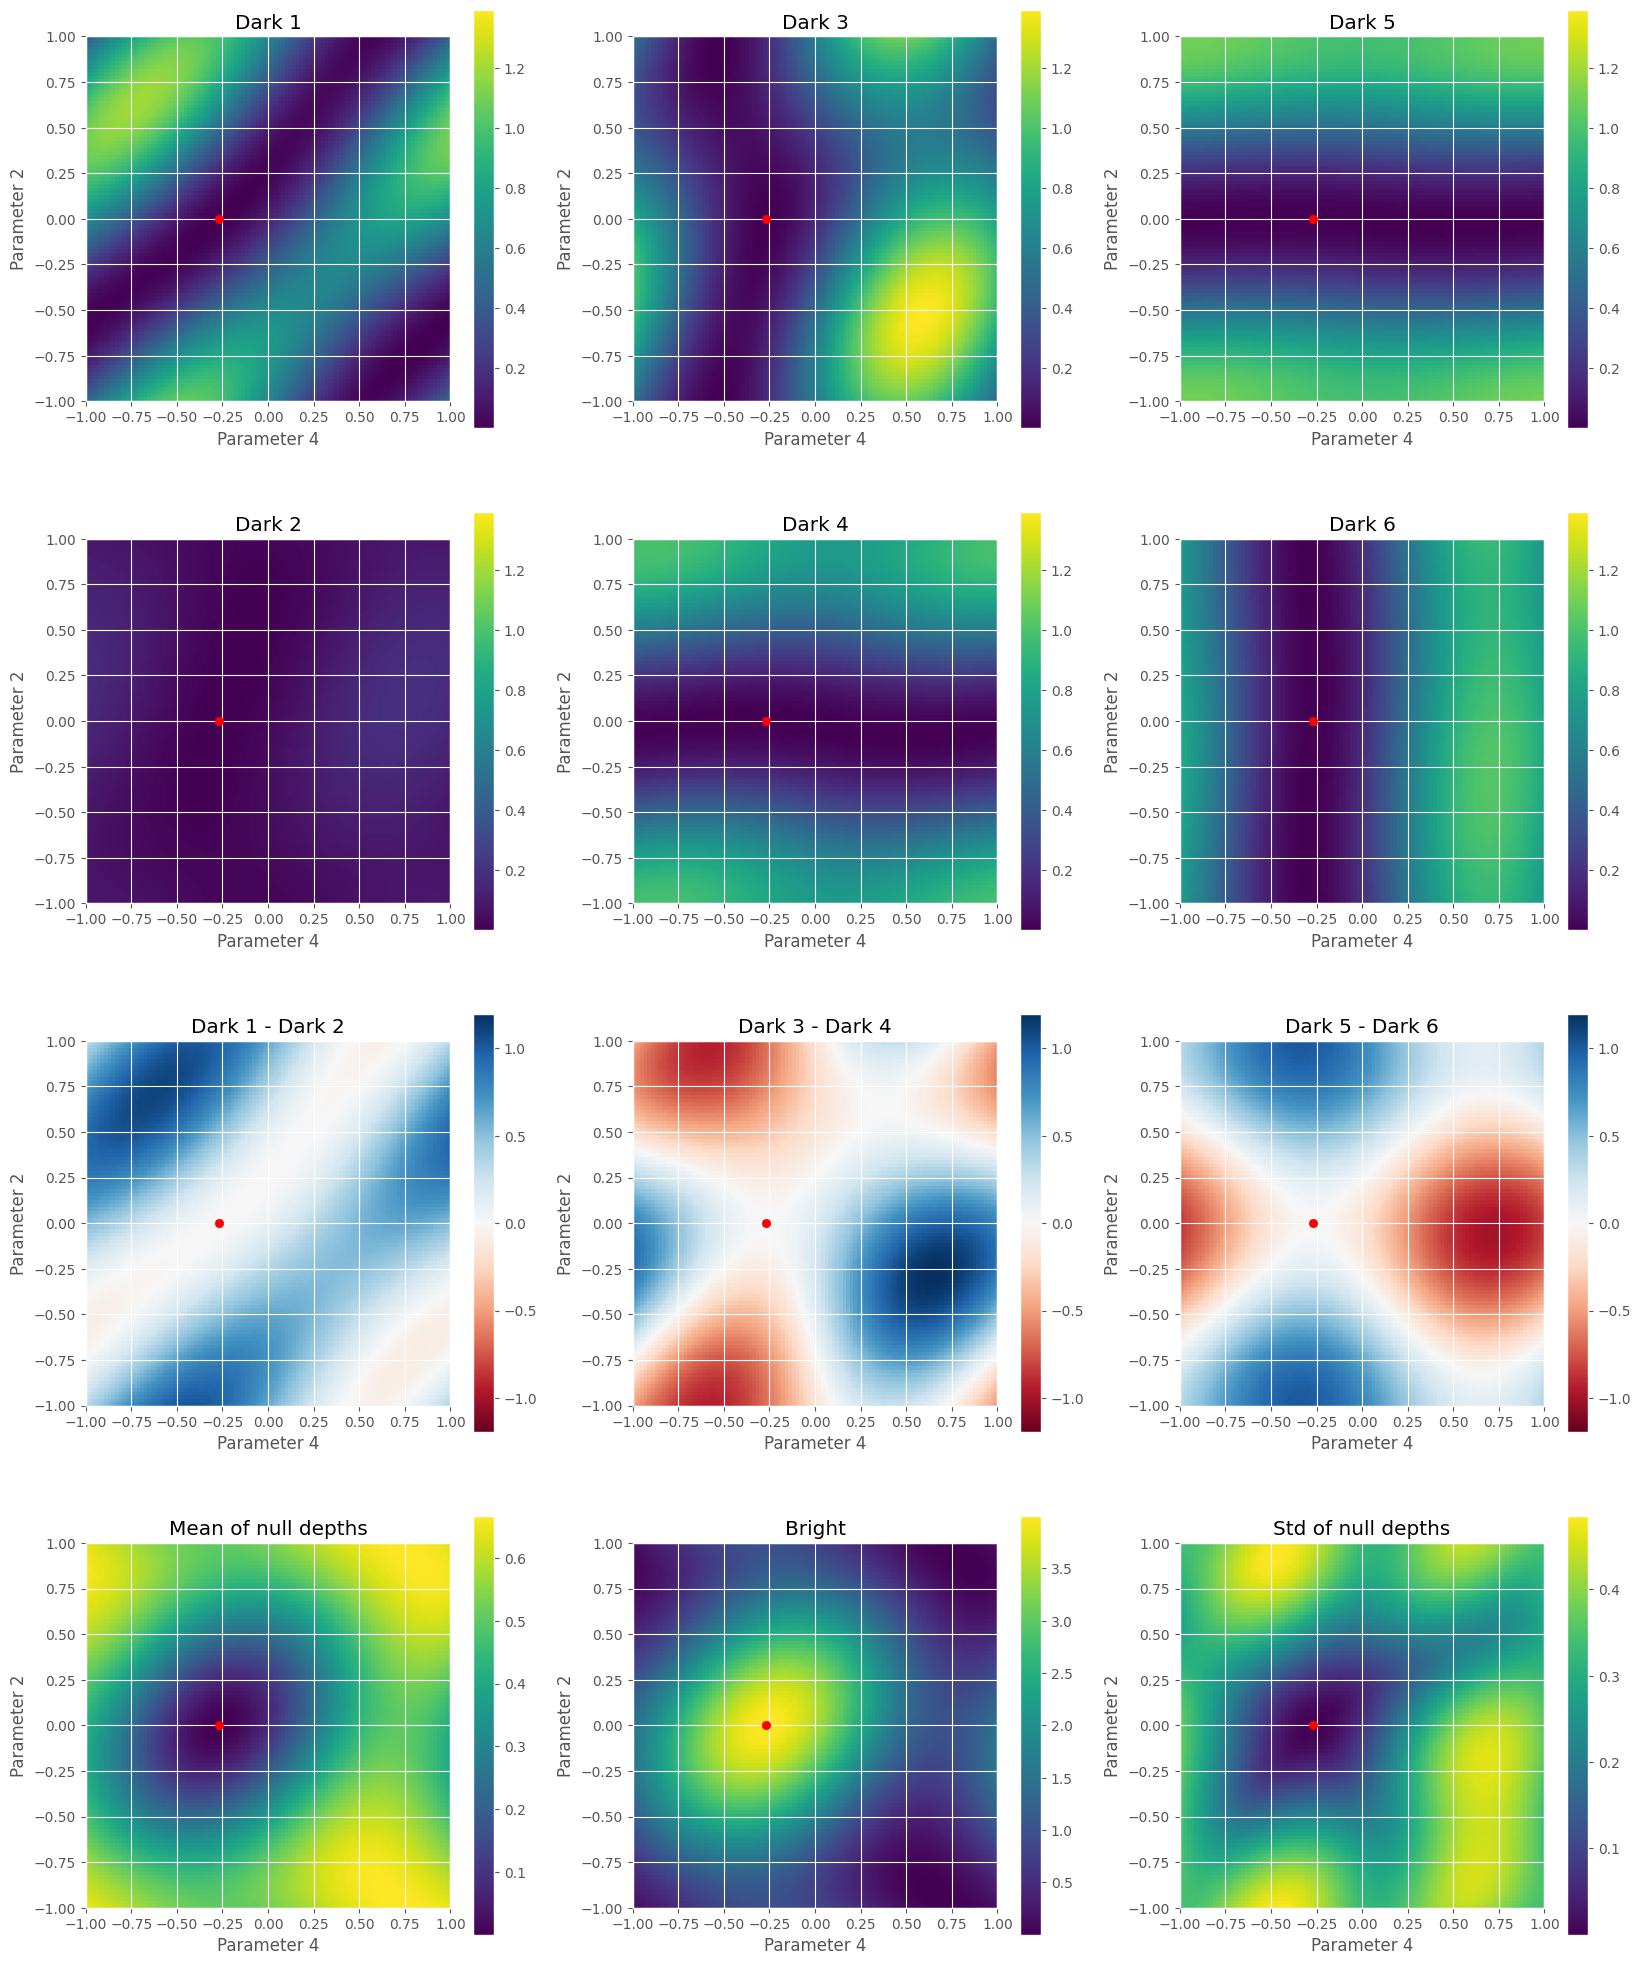

In [71]:
utils.scan(
    kn=kn0, 
    beams=star_light,
    scan_on=(2,4),
    initial_parameters=optimized_parameters,
    optimized_parameters=optimized_parameters,
    plot_intermediate_states=True
)

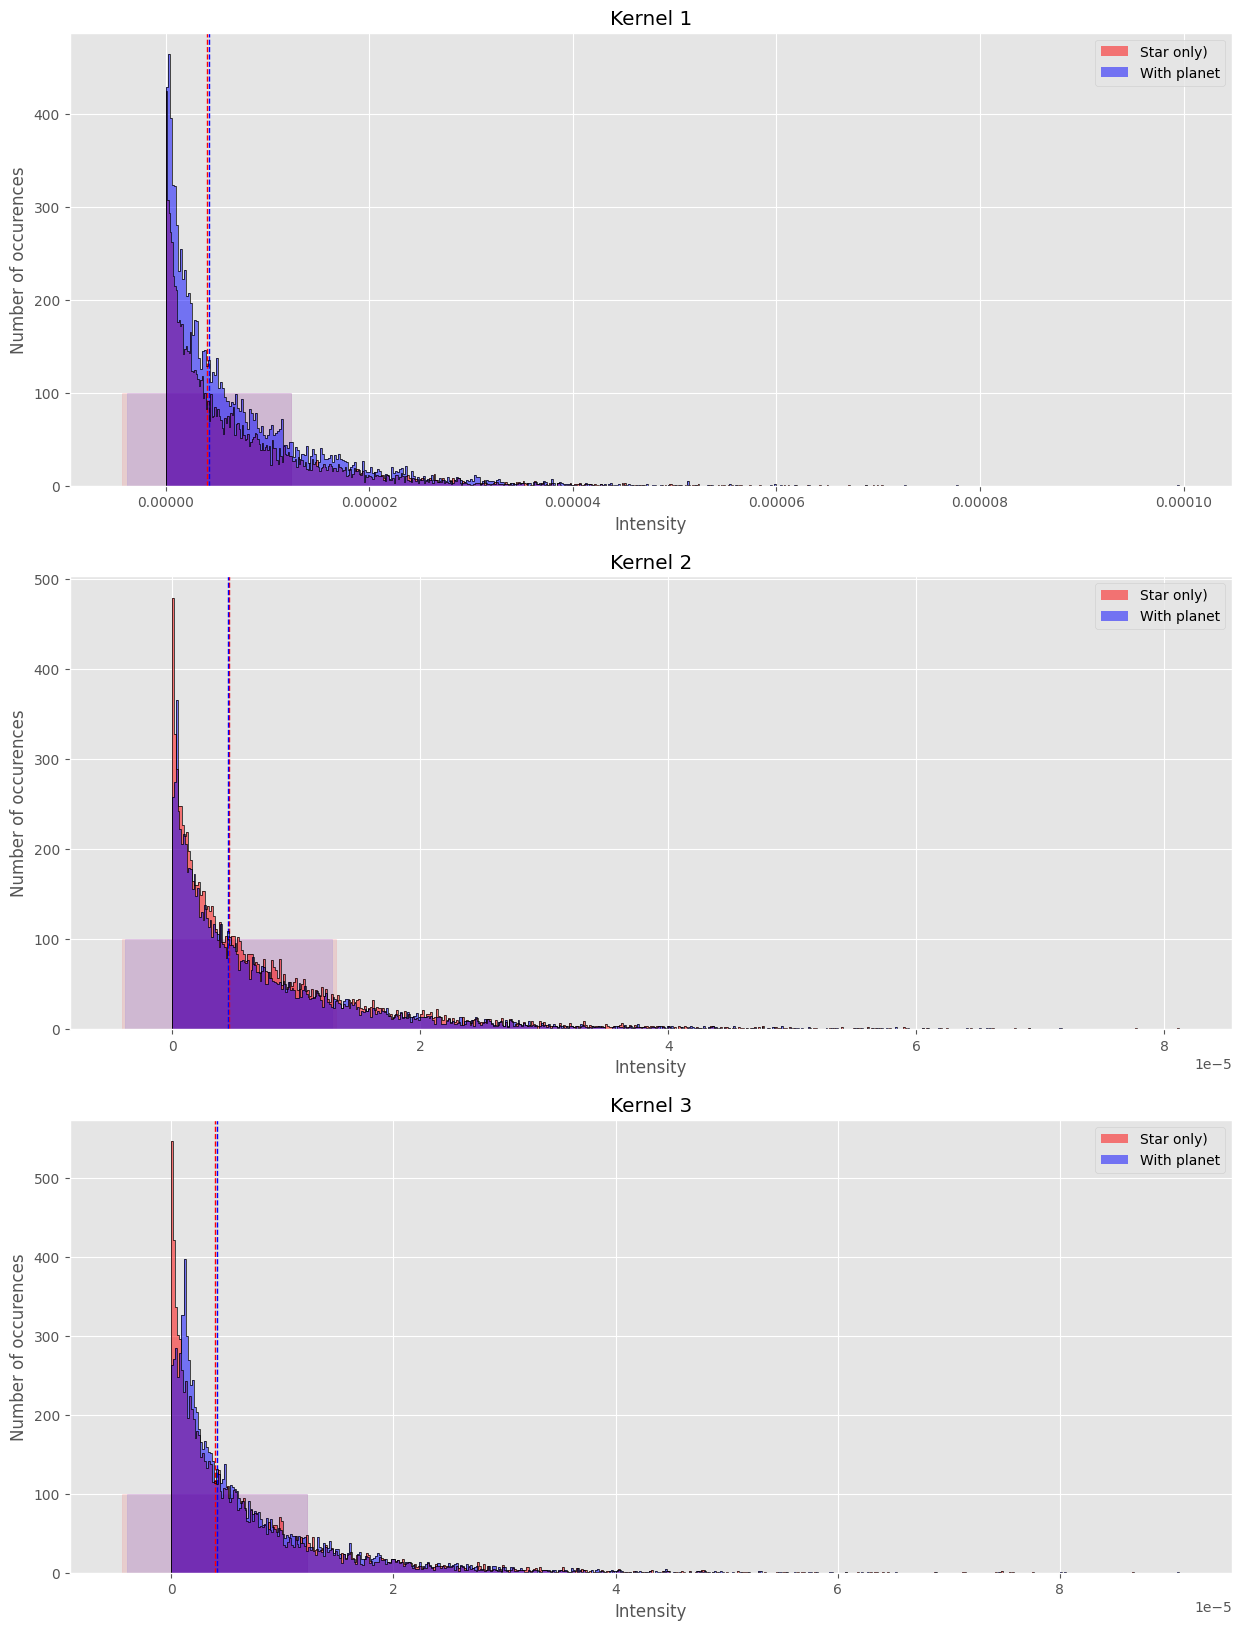

Detection confidence: 50.73%


In [72]:
N = 10000

star_only = [[],[],[]]
for i in range(N):
    kn0.noise_input_shifters()
    _, darks, _ = kn0(star_light, optimized_parameters)
    intensities = np.abs(darks)**2

    for j in range(3):
        star_only[j].append(np.abs(intensities[2*j] - intensities[2*j+1]))

with_planet =  [[],[],[]]
for i in range(N):
    kn0.noise_input_shifters()
    _, darks_star, _ = kn0(star_light, optimized_parameters)
    _, darks_planet, _ = kn0(planet_light, optimized_parameters)

    intensities = np.abs(darks_star)**2 + np.abs(darks_planet)**2

    for j in range(3):
        with_planet[j].append(np.abs(intensities[2*j] - intensities[2*j+1]))

estimator = np.median
mean_star_only =  [[],[],[]]
mean_with_planet =  [[],[],[]]
for j in range(3):
    mean_star_only[j] = estimator(star_only[j])
    mean_with_planet[j] = estimator(with_planet[j])

std_estimator = np.std
std_star_only =  [[],[],[]]
std_with_planet =  [[],[],[]]
for j in range(3):
    std_star_only[j] = std_estimator(star_only[j])
    std_with_planet[j] = std_estimator(with_planet[j])

fig, axs = plt.subplots(3, 1, figsize=(15, 20))

for i, ax in enumerate(axs):

    ax.set_xlabel("Intensity")
    ax.set_ylabel("Number of occurences")
    ax.axvline(mean_star_only[i], color='red', linestyle='dashed', linewidth=1)
    ax.axvline(mean_with_planet[i], color='blue', linestyle='dashed', linewidth=1)

    # Plot std as filled area
    ax.fill_betweenx([0, 100], mean_star_only[i]-std_star_only[i], mean_star_only[i]+std_star_only[i], color='red', alpha=0.1)
    ax.fill_betweenx([0, 100], mean_with_planet[i]-std_with_planet[i], mean_with_planet[i]+std_with_planet[i], color='blue', alpha=0.1)

    bins = 500
    ax.hist(star_only[i], bins=bins, alpha=0.5, color="red", label=f"Star only)")
    ax.hist(with_planet[i], bins=bins, alpha=0.5, color="blue", label=f"With planet")

    ax.hist(star_only[i], bins=bins, histtype='step', color='black')
    ax.hist(with_planet[i], bins=bins, histtype='step', color='black')

    ax.set_title(f"Kernel {i+1}")
    ax.legend()

plt.show()

detection = 0
for i in range(N):
    for j in range(3):
        if with_planet[j][i] > star_only[j][i]:
            detection += 1

print(f"Detection confidence: {detection/(N*3):.2%}")